# MLSP_Assignment4

## By Sumeet Mishra

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pwd
%cd drive/My Drive/MLSP/Assign4/data
%pwd

/content/drive/My Drive/MLSP/Assign4/data


'/content/drive/My Drive/MLSP/Assign4/data'

In [3]:
%ls -ltr

total 7747
-rw------- 1 root root    2549 Mar 28 17:49 concentric.mat
-rw------- 1 root root  319464 Mar 28 17:49 Piano_Clap.wav
-rw------- 1 root root    1952 Mar 28 17:49 MuSigma.mat
-rw------- 1 root root   89404 Mar 28 17:49 mfcc.mat
-rw------- 1 root root 7518860 Mar 28 17:49 MDS_pdist.mat


In [0]:
import cv2 as cv
import numpy as np
import math
import scipy.io
from scipy.io import wavfile
from scipy.io import loadmat
import random
import IPython
import librosa
import glob
import pandas as pd
from scipy.stats import multivariate_normal as mul_n
from matplotlib import pyplot as plt
from collections import OrderedDict
from collections import defaultdict

# P1: When to applaud?

In [0]:
s, sr=librosa.load('Piano_Clap.wav', sr=None)

In [6]:
IPython.display.Audio("Piano_Clap.wav")

In [7]:
dat=loadmat('mfcc.mat')
dat

{'X': array([[ -9.59707791, -10.1109896 ,  -2.12095833, ..., -16.34098793,
         -15.04408113, -14.78239107],
        [ -2.76689826,  -2.33833407,   3.67405982, ...,  -8.95042925,
          -4.79092202,  -6.47048961],
        [ -5.15396131,  -5.10935518,  -1.02791684, ...,  -3.64511271,
          -1.88714029,  -3.29706347],
        ...,
        [  2.60156788,  -3.82018637,  -7.71536205, ...,   3.23812323,
          -7.72872338,  -2.93411992],
        [  1.41347649,   0.56192022,   2.42451385, ...,  -3.59675668,
          -6.35500873,  -4.87596432],
        [  4.19870675,   9.71611983,  -6.61095062, ...,   8.62840831,
           1.94354506,  -1.92230132]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Mar 24 16:31:07 2017',
 '__version__': '1.0'}

In [8]:
mfcc=dat['X']
mfcc.shape

(12, 962)

In [0]:
muSigma=loadmat('MuSigma.mat')

In [10]:
mu_sigma=muSigma['mX']
mu_sigma.shape

(12, 2)

In [11]:
sigma=muSigma['Sigma']
sigma.shape

(12, 12, 2)

In [0]:
piano_mean = mu_sigma[:,0]
claps_mean = mu_sigma[:,1]
piano_cov = sigma[:,:,0]
claps_cov = sigma[:,:,1]

In [13]:
p_matrix = np.array([mul_n.pdf(mfcc.T, mean=piano_mean, cov=piano_cov),mul_n.pdf(mfcc.T, mean=claps_mean, cov=claps_cov)])
p_matrix.shape

(2, 962)

In [0]:
p_sum=np.sum(p_matrix,axis = 0)
p_normalize = p_matrix/p_sum

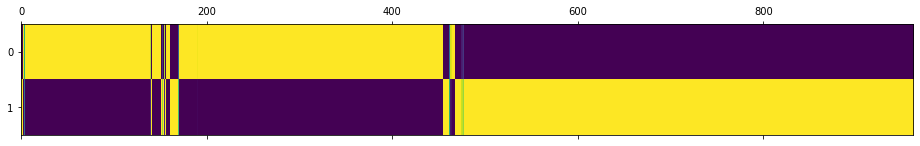

In [15]:
plt.matshow(p_normalize,aspect='auto')

In [0]:
transition_mat = np.array([[0.9,0.1],[0,1]])
smoothen_mat = np.zeros_like(p_normalize)
smoothen_mat[:,0] = p_normalize[:,0]

for i in range(0,smoothen_mat.shape[1]-1):
  b  = np.argmax(smoothen_mat[:,i])
  r_trans = transition_mat[b,:] 
  smoothen_mat[:,i+1] = r_trans*p_normalize[:,i+1]
  smoothen_mat[:,i+1] = smoothen_mat[:,i+1]/np.sum(smoothen_mat[:,i+1])

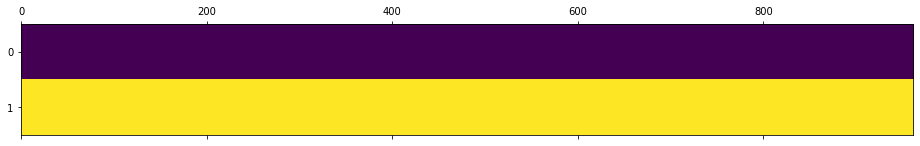

In [17]:
plt.matshow(smoothen_mat, aspect = "auto")

No. Looks like the both claps and piano sound separated as 2 indivisual sound not a continous one.

In [0]:
p_normalize_new = p_normalize.copy()
smoothen_mat_new = np.zeros_like(p_normalize_new)
smoothen_mat_new[:,0] = p_normalize_new[:,0]
max_val = defaultdict(dict)
max_val[0][0] = ''
max_val[0][1] = ''
for t in range(1,smoothen_mat_new.shape[1]):
    for c in range(smoothen_mat_new.shape[0]):
        b  = np.argmax(smoothen_mat_new[:,t-1]*transition_mat[:,c])
        max_val[t][c] = max_val[t-1][b] + str(c)  
        smoothen_mat_new[c,t] = transition_mat[b,c]*smoothen_mat_new[b,t-1]*p_normalize_new[c,t]
    smoothen_mat_new[:,t] = smoothen_mat_new[:,t]/np.sum(smoothen_mat_new[:,t])

In [0]:
max_prob = np.argmax(smoothen_mat_new[:,-1])

In [0]:
max_seq = list(max_val[smoothen_mat_new.shape[1]-1][max_prob])
max_seq = list(map(int,max_seq))
seq_mat = np.zeros((2,len(max_seq)))
seq_mat[0,:] = np.array(max_seq)
seq_mat[1,:] = 1-np.array(max_seq)

([<matplotlib.axis.YTick at 0x7f1b37d90908>,
 [Text(0, 0, 'Piano'), Text(0, 0, 'Claps')])

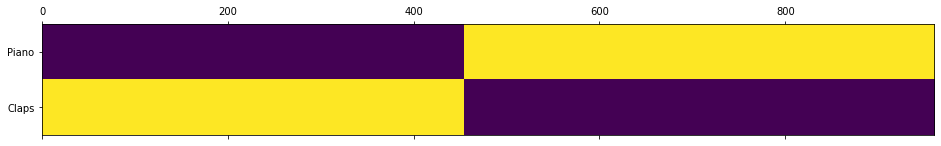

In [21]:
plt.matshow(seq_mat, aspect = "auto")
ylabels=["Piano","Claps"]
plt.yticks(seq_mat[:,0],ylabels)

Yes, this plot makes more sense as we could see the change of sound from piano to claps after the show is over in continuous manner.


# P2: Multidimensional Scaling 

In [22]:
data=loadmat('MDS_pdist.mat')
data

{'L': array([[0.00000000e+00, 5.44312269e+00, 2.67017193e+01, ...,
         6.07884921e+03, 6.13357512e+03, 6.36068812e+03],
        [5.44312269e+00, 0.00000000e+00, 9.11488327e+00, ...,
         5.91838401e+03, 5.95547373e+03, 6.16930480e+03],
        [2.67017193e+01, 9.11488327e+00, 0.00000000e+00, ...,
         5.96693055e+03, 5.97925005e+03, 6.17815366e+03],
        ...,
        [6.07884921e+03, 5.91838401e+03, 5.96693055e+03, ...,
         0.00000000e+00, 1.70591650e+01, 4.68013768e+01],
        [6.13357512e+03, 5.95547373e+03, 5.97925005e+03, ...,
         1.70591650e+01, 0.00000000e+00, 8.10373912e+00],
        [6.36068812e+03, 6.16930480e+03, 6.17815366e+03, ...,
         4.68013768e+01, 8.10373912e+00, 0.00000000e+00]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Mar 24 23:24:22 2017',
 '__version__': '1.0'}

In [0]:
mds=data['L']

In [24]:
mean_mds_c = np.mean(mds, axis = 1)
mds -= mean_mds_c
mean_mds_r = np.mean(mds, axis = 0)
mds -= mean_mds_r
mds

array([[-3885.01261834, -3657.25213779, -3467.71149285, ...,
         2512.06170448,  2810.81723176,  3087.16599642],
       [-3879.56949565, -3662.69526048, -3485.29832893, ...,
         2351.59650831,  2632.71584604,  2895.78267659],
       [-3858.310899  , -3653.58037721, -3494.41321219, ...,
         2400.14304297,  2656.49215982,  2904.63153006],
       ...,
       [ 2193.83658955,  2255.68875124,  2472.51733418, ...,
        -3566.78750341, -3305.69872026, -3226.72074832],
       [ 2248.56249873,  2292.77847086,  2484.83683293, ...,
        -3549.72833836, -3322.7578853 , -3265.41838602],
       [ 2475.67550323,  2506.60954126,  2683.74044301, ...,
        -3519.98612658, -3314.65414618, -3273.52212515]])

In [25]:
eigen_val, eigen_vect = np.linalg.eig(mds)
eigen_real_vect=eigen_vect[:, 0:2].real
eigen_real_vect

array([[-0.03910923,  0.06840524],
       [-0.03662902,  0.06654489],
       [-0.03293468,  0.06660948],
       ...,
       [-0.04337319, -0.05697502],
       [-0.0383456 , -0.05766009],
       [-0.03529753, -0.05987897]])

In [26]:
eigen_val

array([-1.33546235e+06+0.00000000e+00j, -7.71835651e+05+0.00000000e+00j,
        2.16195991e-10+2.11482143e-03j,  2.16195991e-10-2.11482143e-03j,
       -1.83886615e-10+2.26561837e-10j, -1.83886615e-10-2.26561837e-10j,
        9.54741184e-11+7.88475369e-11j,  9.54741184e-11-7.88475369e-11j,
        2.62408281e-11+1.14097626e-10j,  2.62408281e-11-1.14097626e-10j,
       -1.22555888e-10+1.92379680e-11j, -1.22555888e-10-1.92379680e-11j,
        1.02529971e-10+2.51642862e-11j,  1.02529971e-10-2.51642862e-11j,
       -2.58703611e-11+9.29018614e-11j, -2.58703611e-11-9.29018614e-11j,
        9.86744554e-11+0.00000000e+00j,  9.29749054e-11+1.80312217e-11j,
        9.29749054e-11-1.80312217e-11j, -6.85148017e-11+5.32314500e-11j,
       -6.85148017e-11-5.32314500e-11j, -8.92329223e-11+9.72351100e-12j,
       -8.92329223e-11-9.72351100e-12j, -8.67163994e-11+0.00000000e+00j,
       -6.92711838e-11+3.00750494e-11j, -6.92711838e-11-3.00750494e-11j,
       -7.03327274e-11+0.00000000e+00j, -8.64615553

In [0]:
original_map = np.dot(mds,eigen_real_vect)

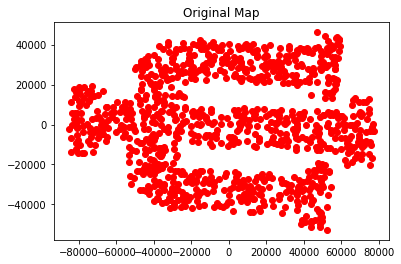

In [28]:
plt.scatter(original_map[:, 0],original_map[:, 1], c = 'red')
plt.title('Original Map')
plt.show()

In [29]:
original_map.shape

(996, 2)

In [30]:
new_rot=[[np.cos(-278),np.sin(-288)],[np.sin(-288),np.cos(-281.1)]]
new_rot

[[0.030944901828293042, 0.8555043707508208],
 [0.8555043707508208, -0.07247888825350433]]

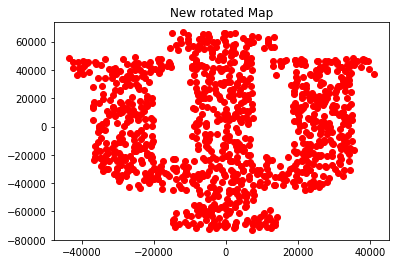

In [31]:
new_map=np.dot(original_map,new_rot)
plt.scatter(new_map[:, 0], new_map[:, 1], c = 'red')
plt.title('New rotated Map')
plt.show()

# P3: Kernel PCA

In [32]:
data=loadmat('concentric.mat')
data

{'X': array([[ 1.03010449e-01,  9.98893136e-02,  8.01525071e-02,
          9.01637216e-02,  9.42734263e-02,  9.67806758e-02,
          7.83636885e-02,  5.38195625e-02,  5.57237608e-02,
          4.69538050e-02,  3.26034026e-02,  1.69590659e-02,
          5.94388496e-03, -6.50218740e-03, -2.12074823e-02,
         -3.06603685e-02, -4.25259333e-02, -5.97044802e-02,
         -7.10441002e-02, -7.55207155e-02, -7.15659692e-02,
         -8.30744108e-02, -9.88110424e-02, -1.06121124e-01,
         -1.04544158e-01, -9.56139964e-02, -1.01646048e-01,
         -8.36424651e-02, -1.00619615e-01, -8.25826182e-02,
         -9.51582875e-02, -6.97758861e-02, -6.14712499e-02,
         -5.11961447e-02, -5.11046944e-02, -3.24007131e-02,
         -1.58489351e-02, -5.46457570e-03,  6.96449122e-03,
          1.92327526e-02,  3.29601325e-02,  3.75675024e-02,
          4.99079743e-02,  6.58753056e-02,  6.00910642e-02,
          8.09744514e-02,  9.15559690e-02,  8.38286757e-02,
          9.36023555e-02,  1.107037

In [33]:
concentric=data['X']
concentric=concentric.T
concentric.shape

(152, 2)

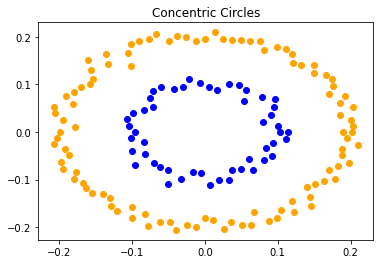

In [34]:
plt.scatter(concentric[51:,0],concentric[51:,1],c='orange')
plt.scatter(concentric[:51,0],concentric[:51,1],c='blue')
plt.title('Concentric Circles')
plt.show()

In [0]:
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D as ax

In [0]:
def pca_kernel(data,gamma,n_features):
  distance_mat=pdist(data,'sqeuclidean')
  sqr_distance_mat = squareform(distance_mat)
  sqr_distance_mat = np.exp(-gamma * sqr_distance_mat) 
  eig_val, eig_vect = np.linalg.eig(sqr_distance_mat)
  eig_val, eigvect = eig_val[::-1], eig_vect[:, ::-1]
  final_data_mat = np.column_stack([eig_vect[:, i]
                           for i in range(n_features)])
  y = np.matmul(sqr_distance_mat,final_data_mat)
  return y.real

In [37]:
final_concentric=pca_kernel(concentric,100,3)
final_concentric.shape

(152, 3)

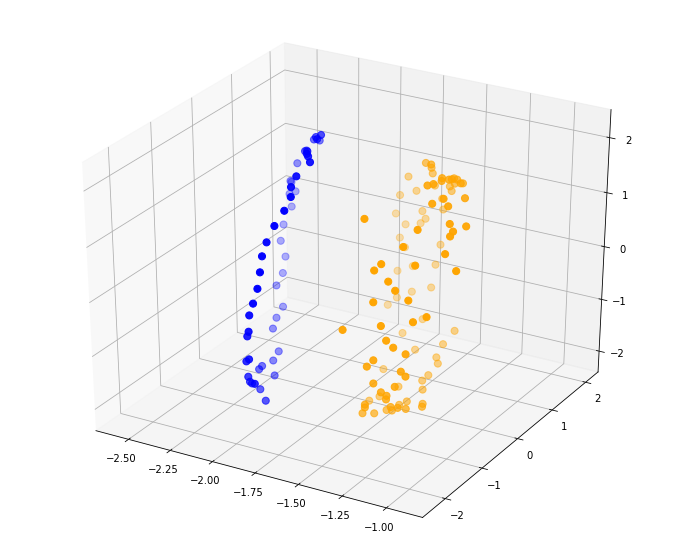

In [38]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_concentric[51:,0],final_concentric[51:,1],final_concentric[51:,2], s=50, c='orange', marker='o')
ax.scatter(final_concentric[:51,0],final_concentric[:51,1],final_concentric[:51,2], s=50, c='blue', marker='o')

In [39]:
final_concentric=final_concentric.T
final_concentric=np.append(final_concentric,[1]*152)
final_concentric=final_concentric.reshape(4,152)
final_concentric.shape

(4, 152)

In [40]:
weight_mat=np.random.rand(1,4)
#weight_mat=np.random.normal(0,1,4)
weight_mat=weight_mat.reshape(4,)
#weight_mat=np.random.uniform(size=4)-0.5
weight_mat.shape

(4,)

In [41]:
weight_mat

array([0.83920399, 0.72424062, 0.31406021, 0.41213022])

In [0]:
def sig_fun(mat):
  mat2=mat.reshape(mat.shape[1],)
  #print(mat2.shape)
  for i in range(len(mat2)):
    print(mat2[i])
    z = 1/(1 + np.exp(-mat2[i]))
    #print(z)
    if z>0.5:
      mat2[i]=1
    else:  
      mat2[i]=0
  mat2=mat2.reshape(1,len(mat2))    
  return mat2


In [43]:
t=[0]*51
t2=[1]*101
t.extend(t2)
t=np.array(t)
t.shape

(152,)

In [44]:
t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
def sig_fun2(mat):
   z = 1/(1 + np.exp(-mat))
   return z

In [0]:
err=[]
acc=[]

In [47]:
weight_mat.shape,final_concentric.shape

((4,), (4, 152))

In [0]:
learning_rate=1e-3
for i in range(500):
  z1=np.matmul(weight_mat,final_concentric)
  y_pred=sig_fun2(z1)
  bp=(y_pred - t)*y_pred*(1-y_pred)
  delta_w=np.matmul(bp,(final_concentric.T))
  weight_mat=weight_mat-(learning_rate*delta_w)
  error=((y_pred-t)**2)/2
  err.append(np.sum(error))
  acc.append(np.equal(np.where(y_pred >= 0.5,1,0),t).sum()/152)

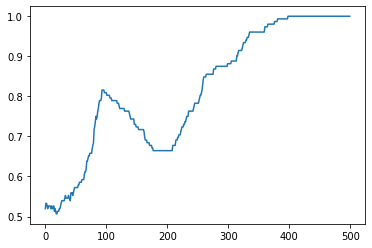

In [49]:
plt.plot(acc)

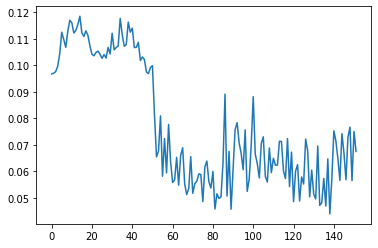

In [50]:
plt.plot(error)


# P4: Neural Networks

In [51]:
concentric.shape

(152, 2)

In [52]:
nn_concentric=concentric.T
nn_concentric=np.append(nn_concentric,[1]*152)
nn_concentric=nn_concentric.reshape(3,152)
nn_concentric.shape

(3, 152)

In [53]:
w1=np.random.uniform(-0.3,0.3,size=(3,3))
w2=np.random.uniform(-0.3,0.3,size=(3))
#w1=0.0001*np.random.randn(3,3)+0
#w2=0.0001*np.random.randn(1,3)+0
w2=w2.reshape(1,3)
w1.shape,w2.shape

((3, 3), (1, 3))

In [54]:
w1

array([[-0.2386814 ,  0.01281834, -0.104576  ],
       [ 0.01561594,  0.27548611,  0.00259681],
       [ 0.08682887,  0.22544941,  0.16066059]])

In [55]:
w2

array([[ 0.28788844, -0.1589601 ,  0.17257254]])

In [0]:
err0=[]
acc0=[]
learning_rate=0.1
for i in range(25000):
  z1=np.matmul(w1,nn_concentric)
  x2=sig_fun2(z1)
  z2=np.matmul(w2,x2)
  y_pred=sig_fun2(z2)

  bp2=(y_pred - t)*y_pred*(1-y_pred)
  #print(bp2)
  delta_w2=np.matmul(bp2,x2.T)
  #print(delta_w2)
  w2=w2-(learning_rate*delta_w2)
  

  bp1=np.matmul(w2.T,bp2)*x2*(1-x2)
  delta_w1=np.matmul(bp1,(nn_concentric.T))
  #print(delta_w1)

  w1=w1-(learning_rate*delta_w1)
  #print(delta_w2)

  error=((y_pred-t)**2)/2
  err0.append(np.sum(error))
  acc0.append(np.equal(np.where(y_pred >= 0.5,1,0),t).sum()/152)

In [57]:
w2.shape,x2.shape

((1, 3), (3, 152))

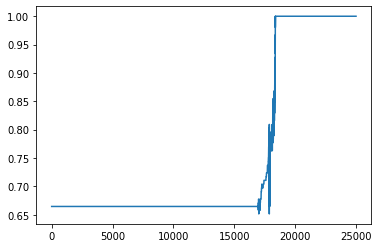

In [58]:
plt.plot(acc0)

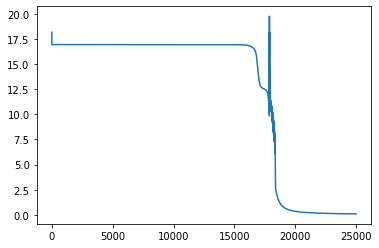

In [59]:
plt.plot(err0)

In [60]:
max(acc0)

1.0